-- Выделены все признаки:  [1, 1, 1, 1, 1, 1, 1, 1, 1] , верность =  0.9398972250770811
gen	nevals	max     	avg     
0  	50    	0.947357	0.907666
1  	41    	0.947357	0.929996
2  	40    	0.947357	0.935076
3  	43    	0.947928	0.936512
4  	42    	0.947928	0.936709
5  	38    	0.947928	0.938331
6  	43    	0.947928	0.939578
7  	41    	0.947928	0.938041
8  	44    	0.947928	0.941254
9  	44    	0.947928	0.938834
10 	42    	0.947928	0.941636
11 	42    	0.947928	0.941306
12 	41    	0.947928	0.940951
13 	39    	0.947928	0.941995
14 	44    	0.947928	0.937789
15 	44    	0.947928	0.942073
16 	43    	0.947928	0.942669
17 	41    	0.947928	0.945098
18 	42    	0.947928	0.926698
19 	44    	0.947928	0.943858
20 	44    	0.947928	0.943246
- Лучшие решения:
0 :  [0, 0, 1, 0, 0, 1, 0, 0, 0] , приспособленность =  0.9479280575539568 , верность =  0.9499280575539568 , признаков =  2
1 :  [0, 0, 1, 0, 1, 1, 1, 0, 1] , приспособленность =  0.9477749229188078 , верность =  0.9527749229188078 , признаков =  5
2 :  [

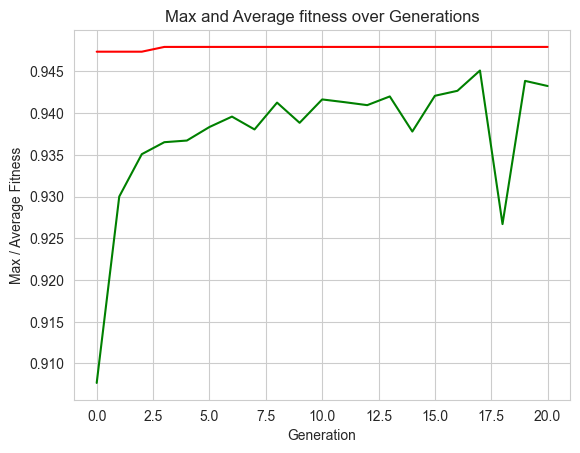

In [1]:
import deap
from deap import tools
from deap import algorithms
import random
from pandas import read_csv
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from deap import base
from deap import creator
from deap import tools
import random
import numpy
import matplotlib.pyplot as plt
import seaborn as sns


def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
                        halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook


class Zoo:

    NUM_FOLDS = 5

    def __init__(self, randomSeed):

        self.randomSeed = randomSeed

        self.data = read_csv('breast-cancer-wisconsin1.data',
                             header=None, usecols=range(1, 11))

        self.X = self.data.iloc[:, 0:9]
        self.y = self.data.iloc[:, 9]

        self.kfold = model_selection.KFold(
            n_splits=self.NUM_FOLDS, random_state=self.randomSeed, shuffle=True)

        self.classifier = DecisionTreeClassifier(random_state=self.randomSeed)

    def __len__(self):
        return self.X.shape[1]

    def getMeanAccuracy(self, zeroOneList):

        zeroIndices = [i for i, n in enumerate(zeroOneList) if n == 0]
        currentX = self.X.drop(self.X.columns[zeroIndices], axis=1)

        cv_results = model_selection.cross_val_score(
            self.classifier, currentX, self.y, cv=self.kfold, scoring='accuracy')

        return cv_results.mean()


def main():
    zoo = Zoo(randomSeed=42)

    allOnes = [1] * len(zoo)
    print("-- Выделены все признаки: ", allOnes,
          ", верность = ", zoo.getMeanAccuracy(allOnes))


if __name__ == "__main__":
    main()


POPULATION_SIZE = 50
P_CROSSOVER = 0.9  # provability for crossover
P_MUTATION = 0.3  # provability for mutating an individual
MAX_GENERATIONS = 20
HALL_OF_FAME_SIZE = 5
FEATURE_PENALTY_FACTOR = 0.001
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# create the Zoo test class:
zoo = Zoo(RANDOM_SEED)

toolbox = base.Toolbox()

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox.register("zeroOrOne", random.randint, 0, 1)

toolbox.register("individualCreator", tools.initRepeat,
                 creator.Individual, toolbox.zeroOrOne, len(zoo))

toolbox.register("populationCreator", tools.initRepeat,
                 list, toolbox.individualCreator)

# fitness calculation:


def zooClassificationAccuracy(individual):
    numFeaturesUsed = sum(individual)
    if numFeaturesUsed == 0:
        return 0.0,
    else:
        accuracy = zoo.getMeanAccuracy(individual)
        return accuracy - FEATURE_PENALTY_FACTOR * numFeaturesUsed,  # return a tuple


toolbox.register("evaluate", zooClassificationAccuracy)
# genetic operators:mutFlipBit
toolbox.register("select", tools.selTournament, tournsize=2)

toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutFlipBit, indpb=1.0 / len(zoo))


def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", numpy.max)
    stats.register("avg", numpy.mean)
    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = eaSimpleWithElitism(
        population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION, ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best solutin found:
    print("- Лучшие решения:")
    for i in range(HALL_OF_FAME_SIZE):
        print(i, ": ", hof.items[i], ", приспособленность = ", hof.items[i].fitness.values[0],
              ", верность = ", zoo.getMeanAccuracy(hof.items[i]), ", признаков = ", sum(hof.items[i]))

    # extract statistics:
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color="red")
    plt.plot(meanFitnessValues, color="green")
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average fitness over Generations')
    plt.show()


if __name__ == "__main__":
    main()
